# Notebook for Gradient Descent

Re-fit a part of the database with the Gradient Descent algorithm instead of Levenberg-Marquardt

In [10]:
import scipy as sp
import scipy.optimize
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
from hashlib import sha256

from utils_fit import get_anchors_and_scores_mean_curve, convert_table2, remove_rows_with_nan_or_inf, load_from_parts, remove_bad_fits, failed_fits_statistics,  prepare_total_dataframe, plot_data2, plot_trn_data2, plot_prediction2, plot_prediction_smooth2, get_fun_model_id, get_XY2, get_ranks_from_tables, build_rank_table, convert_to_cd_tables, filter_table, prepare_data_for_cd, make_all_cd_plots, print_pretty_rank_table_transpose, plot_metric, get_relevant_max_anchor, empirical_cdf
from fit_database_GD import fit_model, get_multiple_extrapolations_mean_curve_robust, df_compute_metrics_mean_curve

dir_plots = 'plots_GD'
dir_fitting_results = 'fitting_results_GD'

In [11]:
# fn_df_total = dir_fitting_results + '/df_total.gz'
# if exists(fn_df_total):
#     df_total = pd.read_pickle(fn_df_total)
# else:
[df_anchors_and_scores, df_metrics, df_extrapolations] = load_from_parts(dir_fitting_results)
df_total = prepare_total_dataframe(df_anchors_and_scores, df_metrics, df_extrapolations)
df_total.to_pickle(fn_df_total, protocol=3)

  0%|          | 0/246 [00:00<?, ?it/s]

# Re-fitting one learning curve

First, show the pre-computed learning curve from the database. Then, re-fit it and compare. 

visualizing the curve fit of row number 93934


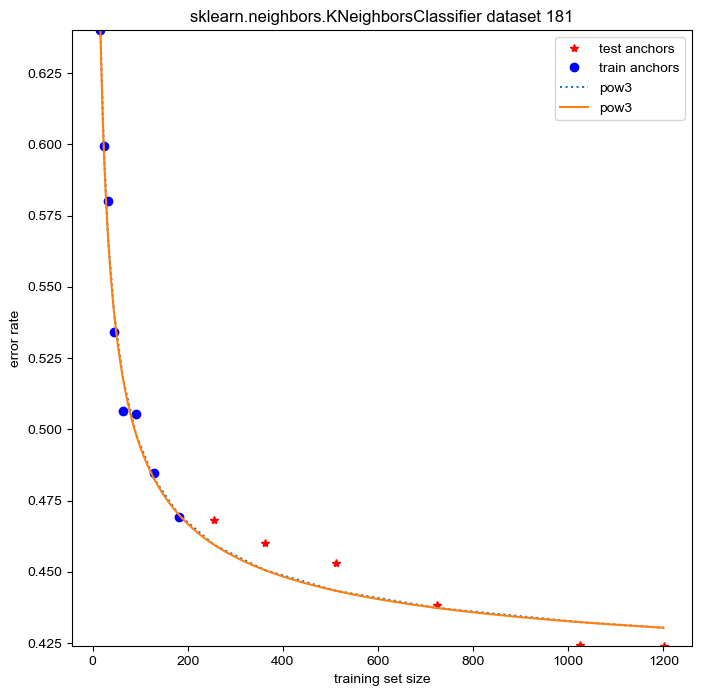

openmlid                                                           181
learner                         sklearn.neighbors.KNeighborsClassifier
max_anchor_seen                                                    181
prediction           [0.357920281245251, 0.40020899448548286, 0.431...
beta                 [0.5911998444754079, 1.075267323016772, 0.5511...
fails_init                                                           0
fails_fit                                                            0
MSE_trn                                                       0.000046
MSE_tst                                                       0.000062
MSE_tst_last                                                  0.000042
L1_trn                                                        0.005221
L1_tst                                                        0.007233
L1_tst_last                                                    0.00651
n                                                                    8
curve_

In [14]:
num = np.random.randint(0,len(df_total))
row = df_total.iloc[num,:]

print('visualizing the curve fit of row number %d' % num)

plt.figure(figsize=(8,8))

# plots all the points on the curve (red stars)
plot_data2(row)

# plots the points used for training only (blue dots)
plot_trn_data2(row)

# plot the curve fit from the row of the dataframe (dotted)
plot_prediction2(row)

# plot the curve fit using the beta parameters in the dataframe (line)
# this plot is smoother since we can predict any x-value
# this curve should overlap with the curve plotted previously
plot_prediction_smooth2(row)

# show the plot
plt.show()

# show the information of the row
print(row)

In [4]:
# get the X and Y values
# X are training set sizes
# Y are accuracies
[X, Y] = get_XY2(row)

# we need to find the training and test set for the curve data, we do that through the offset
offset = np.argwhere(X == row.max_anchor_seen)[0][0]

# curve training data
X_trn_curve = np.array(X[:offset + 1])
Y_trn_curve = np.array(Y[:offset + 1])

# curve testing data
X_tst_curve = np.array(X[offset + 1:])
Y_tst_curve = np.array(Y[offset + 1:])

experiment_id = '%d-%s-%s-%d' % (row.openmlid,row.learner,row.curve_model,offset)

hash = sha256(experiment_id.encode())
seed = np.frombuffer(hash.digest(), dtype='uint32')
np.random.seed(seed)

# fit the curve model again
[beta_fit_new, fitted_curve_model_new, fails_init, fails_fit] = fit_model(X_trn_curve, Y_trn_curve, X_tst_curve, row.curve_model)

print('best beta found from fitting procedure:')
print(beta_fit_new)
print('the beta provided by the authors:')
print(row.beta)
#assert(beta_fit_new == row.beta)

Optimization terminated successfully.
         Current function value: 0.006068
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.006097
         Iterations: 4
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.006081
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.005965
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.005909
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.005909
         Iterations: 1
         Function evaluations: 12
         Grad

# Re-fit one dataset

In [5]:
# all the performances
df_performances = pd.read_csv("database-accuracy.csv")

In [6]:
# only performances from dataset 1468
df_performances_one_dataset = df_performances.sample(n=5000)
df_performances_one_dataset

openmlid                                  learner  size_train  \
730324         31                                  SVC_rbf          64   
1905586        22                               SVC_linear          23   
785957        847   sklearn.neighbors.KNeighborsClassifier          32   
1883503        14     sklearn.linear_model.RidgeClassifier         362   
1585306       991     sklearn.neural_network.MLPClassifier          91   
...           ...                                      ...         ...   
278104         32         sklearn.tree.ExtraTreeClassifier          64   
994858      41169       sklearn.linear_model.SGDClassifier         512   
1636134     41159  sklearn.linear_model.LogisticRegression          32   
416584      23512     sklearn.linear_model.RidgeClassifier        4096   
942077         16         sklearn.tree.ExtraTreeClassifier         724   

         size_test  outer_seed  inner_seed  traintime  score_train  \
730324         100           2           4     0.0024       0.8594   
1905586        200           2          11     0.0091       1.0000   
785957         658           4           0     0.0005       0.8125   
1883503        200           0           5     0.0031       0.8370   
1585306        173           2           3     0.1581       1.0000   
...            ...         ...         ...        ...          ...   
278104        1100           4           0     0.0005       1.0000   
994858        5000           1           3     0.1509       0.0625   
1636134       2000           3           3     0.0544       1.0000   
416584        5000           0           3     0.0051       0.6487   
942077         200           1          19     0.0014       1.0000   

         score_valid  score_test  
730324        0.7000      0.7700  
1905586       0.5167      0.5250  
785957        0.8243      0.8040  
1883503       0.7611      0.7550  
1585306       0.9103      0.9306  
...              ...         ...  
278104        0.5758      0.5964  
994858        0.0530      0.0586  
1636134       0.5350      0.5600  
416584        0.6192      0.6318  
942077        0.5167      0.5150  

[5000 rows x 10 columns]

In [7]:
np.seterr(all='print')

rep = 5
start_time = time.time()
print('computing extrapolations...')
# compute the fits
df_extrapolations = get_multiple_extrapolations_mean_curve_robust(df_performances_one_dataset, rep, True)
df_extrapolations.to_pickle(dir_fitting_results + '/extrapolations_example.gz', protocol=3)

print('computing anchors and scores...')
# compute the X, Y values and store them for later use
df_anchors_and_scores = get_anchors_and_scores_mean_curve(df_performances_one_dataset)
df_anchors_and_scores.to_pickle(dir_fitting_results + '/anchors_scores_example.gz', protocol=3)

print('computing metrics....')
# compute the metrics and other information (L2 losses, etc.)
df_metrics = df_compute_metrics_mean_curve(df_extrapolations, df_anchors_and_scores)
df_metrics.to_pickle(dir_fitting_results + '/metrics_example.gz', protocol=3)

end_time = time.time()
total_time = end_time - start_time
total_time

computing extrapolations...


  0%|                                                 | 0/79360 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.001604
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001031
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.003450
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001905
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003458
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001683
         Iterations: 3
         Function evaluations: 24
         Grad

  0%|                                       | 17/79360 [00:00<09:41, 136.54it/s]

Optimization terminated successfully.
         Current function value: 0.003841
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003390
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003006
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002724
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.004904
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002659
         Iterations: 1
         Function evaluations: 12
         Grad

  0%|                                        | 21/79360 [00:00<14:40, 90.06it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000657
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000657
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000657
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000657
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000657
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000486
         Iterations: 9
         Function evaluations: 120
         Gra

  0%|                                        | 25/79360 [00:00<18:57, 69.74it/s]

         Current function value: 7.538794
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000838
         Iterations: 7
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.002996
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002622
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003842
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003413
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization ter

  0%|                                        | 29/79360 [00:00<21:00, 62.92it/s]

Optimization terminated successfully.
         Current function value: 0.003785
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003995
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000185
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000342
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.003995
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000173
         Iterations: 2
         Function evaluations: 30
         Gra

  0%|                                        | 34/79360 [00:00<21:50, 60.55it/s]Warning: underflow encountered in exp

Optimization terminated successfully.
         Current function value: 0.001008
         Iterations: 2
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001119
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001514
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001450
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001266
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000996
         Iterations: 1
         Function evaluations: 16
         Grad

ntered in exp
  0%|                                        | 49/79360 [00:00<17:52, 73.98it/s]

Optimization terminated successfully.
         Current function value: 0.001663
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001657
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001663
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001663
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001662
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001663
         Iterations: 1
         Function evaluations: 15
         Grad

Optimization terminated successfully.
         Current function value: 0.001618
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.002055
         Iterations: 8
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.001556
         Iterations: 7
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.003794
         Iterations: 6
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.015862
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.013682
         Iterations: 2
         Function evaluations: 16
         

  0%|                                      | 100/79360 [00:00<12:42, 103.98it/s]

Optimization terminated successfully.
         Current function value: 0.002537
         Iterations: 7
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.002212
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.001583
         Iterations: 4
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001615
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.016890
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.014019
         Iterations: 2
         Function evaluations: 16
         Gr

Optimization terminated successfully.
         Current function value: 0.004912
         Iterations: 7
         Function evaluations: 99
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.614161
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.674345
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.674186
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.674063
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.674125
         Iterations: 0
         Function evaluations: 3
         Gradient

  0%|                                       | 105/79360 [00:01<14:07, 93.47it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.005227
         Iterations: 6
         Function evaluations: 36
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.005216
         Iterations: 6
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.005194
         Iterations: 6
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.005194
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.002767
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
         Current function value: 205.095216
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimizati

  0%|                                       | 108/79360 [00:01<15:01, 87.89it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001545
         Iterations: 6
         Function evaluations: 90
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.002092
         Iterations: 8
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.014568
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002338
         Iterations: 15
         Function evaluations: 190
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.014592
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.014598
         Iterations: 2
         Function evaluations: 20
       

  0%|                                       | 112/79360 [00:01<15:45, 83.81it/s]

Optimization terminated successfully.
         Current function value: 0.001874
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.002671
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002723
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002609
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003138
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002916
         Iterations: 2
         Function evaluations: 21
         Grad

  0%|                                       | 117/79360 [00:01<16:19, 80.87it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001825
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002264
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001931
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001702
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002601
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001303
         Iterations: 1
         Function evaluations: 12
         Grad

  0%|                                       | 125/79360 [00:01<16:27, 80.21it/s]

         Current function value: 40.656077
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 27.916949
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 1315.173419
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 2331.962256
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 126.488527
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 12231.027367
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 57.600501
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 14891.735399
        

  0%|                                       | 130/79360 [00:01<16:57, 77.90it/s]

Optimization terminated successfully.
         Current function value: 0.000477
         Iterations: 3
         Function evaluations: 36
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000369
         Iterations: 2
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000336
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000974
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001003
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001019
         Iterations: 2
         Function evaluations: 16
         Grad

  0%|                                       | 138/79360 [00:01<17:00, 77.62it/s]

Optimization terminated successfully.
         Current function value: 0.001797
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001007
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000711
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000708
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001180
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000706
         Iterations: 1
         Function evaluations: 9
         Gradient

Optimization terminated successfully.
         Current function value: 0.001077
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001047
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001077
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001045
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001001
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.001054
         Iterations: 3
     

Optimization terminated successfully.
         Current function value: 0.004926
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.004002
         Iterations: 9
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.014176
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.015924
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002729
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.002734
         Iterations: 0
         Function evaluations: 5
         Gr

  0%|                                       | 145/79360 [00:02<18:24, 71.72it/s]

Optimization terminated successfully.
         Current function value: 0.003200
         Iterations: 8
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.003660
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.002803
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.002875
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003358
         Iterations: 9
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.003939
         Iterations: 3
         Function evaluations: 44
         G

  0%|                                       | 149/79360 [00:02<18:52, 69.97it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.005323
         Iterations: 10
         Function evaluations: 132
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.618133
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.618133
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.671602
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.008284
         Iterations: 12
         Function evaluations: 166
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.671602
         Iterations: 0
         Function evaluations: 3
         Gr

  0%|                                       | 153/79360 [00:02<19:14, 68.61it/s]Warning: underflow encountered in exp


         Current function value: 13894.810528
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.004574
         Iterations: 6
         Function evaluations: 92
         Gradient evaluations: 23
         Current function value: 3612.805565
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.004243
         Iterations: 3
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.004689
         Iterations: 7
         Function evaluations: 81
         Gradient evaluations: 20
         Current function value: 34.966556
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 6520.840802
         Iterations: 0
         Fun

  0%|                                       | 157/79360 [00:02<19:44, 66.87it/s]

Optimization terminated successfully.
         Current function value: 0.012404
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.010961
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.012108
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.013562
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.012041
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.014473
         Iterations: 3
     

Optimization terminated successfully.
         Current function value: 0.007151
         Iterations: 5
         Function evaluations: 56
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.007192
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.007982
         Iterations: 2
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.006374
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.005401
         Iterations: 1
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.005882
         Iterations: 4
         Function evaluations: 56
         Gra

Optimization terminated successfully.
         Current function value: 0.001575
         Iterations: 9
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.001505
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001818
         Iterations: 7
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.001642
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.001663
         Iterations: 6
         Function evaluations: 56
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.001879
         Iterations: 6
         Function evaluations: 72
         

  0%|                                       | 177/79360 [00:02<20:10, 65.39it/s]

Optimization terminated successfully.
         Current function value: 0.001632
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.022546
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001487
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.021480
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001895
         Iterations: 6
         Function evaluations: 56
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.001777
         Iterations: 5
         Function evaluations: 76
         Gra

  0%|                                       | 181/79360 [00:02<20:30, 64.37it/s]Warning: underflow encountered in exp

Optimization terminated successfully.
         Current function value: 0.001857
         Iterations: 5
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.021062
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001996
         Iterations: 7
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.001856
         Iterations: 6
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.001364
         Iterations: 10
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.022348
         Iterations: 3
         Function evaluations: 24
        

ncountered in exp


Optimization terminated successfully.
         Current function value: 0.001659
         Iterations: 8
         Function evaluations: 87
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.001659
         Iterations: 5
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001681
         Iterations: 5
         Function evaluations: 57
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.001659
         Iterations: 4
         Function evaluations: 36
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001659
         Iterations: 4
         Function evaluations: 42
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.004828
         Iterations: 4
         Function evaluations: 30
        

  0%|                                       | 185/79360 [00:02<21:02, 62.71it/s]Warning: underflow encountered in exp


         Current function value: 262398.688080
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.001025
         Iterations: 13
         Function evaluations: 133
         Gradient evaluations: 33
         Current function value: 4493.912774
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 1217.656677
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 1539.276648
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.001133
         Iterations: 8
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.023660
         Iterations: 1
      

  0%|                                       | 188/79360 [00:03<21:43, 60.76it/s]ntered in exp


Optimization terminated successfully.
         Current function value: 0.025191
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001181
         Iterations: 12
         Function evaluations: 145
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.003039
         Iterations: 7
         Function evaluations: 65
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.001536
         Iterations: 9
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.001106
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.025293
         Iterations: 2
         Function evaluations: 20
      

  0%|                                       | 191/79360 [00:03<22:21, 59.03it/s]Warning: underflow encountered in exp

Optimization terminated successfully.
         Current function value: 0.001984
         Iterations: 10
         Function evaluations: 116
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.002038
         Iterations: 3
         Function evaluations: 73
         Gradient evaluations: 18
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.001944
         Iterations: 6
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.002010
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.002649
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002649
         Iterations: 2

erflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.014117
         Iterations: 17
         Function evaluations: 172
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.004850
         Iterations: 3
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004348
         Iterations: 5
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.004669
         Iterations: 5
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.004085
         Iterations: 6
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.018348
         Iterations: 4
         Function evaluations: 28
       

  0%|                                       | 193/79360 [00:03<23:14, 56.76it/s]

Optimization terminated successfully.
         Current function value: 0.008940
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.006785
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.004811
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006267
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.004005
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002920
         Iterations: 2
         Function evaluations: 37
         Gradi

  0%|                                       | 197/79360 [00:03<23:29, 56.16it/s]

Optimization terminated successfully.
         Current function value: 0.000984
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001133
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001346
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000984
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001256
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001836
         Iterations: 1
         Function evaluations: 9
         Gradie

  0%|                                       | 201/79360 [00:03<23:46, 55.49it/s]

Optimization terminated successfully.
         Current function value: 0.004988
         Iterations: 5
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001425
         Iterations: 6
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.001239
         Iterations: 7
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.001263
         Iterations: 7
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.001860
         Iterations: 6
         Function evaluations: 96
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.001259
         Iterations: 7
         Function evaluations: 112
      

  0%|                                       | 205/79360 [00:03<23:58, 55.04it/s]Warning: overflow encountered in scalar power


Optimization terminated successfully.
         Current function value: 0.008503
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.008503
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.008238
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.008503
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.007982
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.007816
         Iterations: 2
         Function evaluations: 20
         Grad

  0%|                                       | 209/79360 [00:03<24:14, 54.42it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.003897
         Iterations: 9
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.003139
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002690
         Iterations: 4
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.002439
         Iterations: 7
         Function evaluations: 102
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.003866
         Iterations: 8
         Function evaluations: 104
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.001749
         Iterations: 5
         Function evaluations: 60
      

  0%|                                       | 223/79360 [00:03<23:18, 56.57it/s]Warning: overflow encountered in scalar power


Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 4
         Function evaluations: 36
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 5
         Function evaluations: 39
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000059
         Iterations: 5
         Function evaluations: 27
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 5
         Function evaluations: 36
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.642011
         Iterations: 2
         Function evaluations: 12
         

  0%|                                       | 233/79360 [00:04<22:56, 57.50it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000333
         Iterations: 14
         Function evaluations: 141
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.746460
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.747892
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000266
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000266
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000266
         Iterations: 2
         Function evaluations: 18
         Gra

  0%|                                       | 241/79360 [00:04<22:59, 57.35it/s]

         Current function value: 834200840974576224251399965085832333425570793286097263098742029867983762910594015766261878464090143146980862211553855183757856236860564437590225736171520.000000
         Iterations: 0
         Function evaluations: 416
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.003528
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001691
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001605
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001461
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.

  0%|                                       | 246/79360 [00:04<23:03, 57.18it/s]

Optimization terminated successfully.
         Current function value: 0.000576
         Iterations: 8
         Function evaluations: 96
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 14
         Function evaluations: 141
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.666302
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.666366
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.666198
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000460
         Iterations: 9
         Function evaluations: 93
         

  0%|                                       | 253/79360 [00:04<22:59, 57.35it/s]

Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002265
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.002265
         Iterations: 5
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.002265
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.002265
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.002265
         Iterations: 5
         Function evaluations: 30
         

  0%|▏                                      | 257/79360 [00:04<23:09, 56.94it/s]

Optimization terminated successfully.
         Current function value: 0.003987
         Iterations: 1
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002428
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002928
         Iterations: 1
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.004822
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001515
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001521
         Iterations: 0
         Function evaluations: 5
         Gradi

  0%|▏                                      | 263/79360 [00:04<23:10, 56.90it/s]

Optimization terminated successfully.
         Current function value: 0.000634
         Iterations: 12
         Function evaluations: 108
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000635
         Iterations: 13
         Function evaluations: 144
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.816511
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.814117
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.816338
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000634
         Iterations: 9
         Function evaluations: 90
        

  0%|▏                                      | 271/79360 [00:04<22:59, 57.32it/s]erflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.005030
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.004510
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001436
         Iterations: 6
         Function evaluations: 70
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.004857
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.004311
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.004857
         Iterations: 1
         Function evaluations: 15
         Gra

  0%|▏                                      | 284/79360 [00:04<22:25, 58.79it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.003657
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.003516
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003613
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.003547
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003516
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003525
         Iterations: 1
         Function evaluations: 12
         Gradi

  0%|▏                                      | 295/79360 [00:04<22:04, 59.72it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.002281
         Iterations: 1
         Function evaluations: 21
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001685
         Iterations: 4
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001194
         Iterations: 3
         Function evaluations: 50
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001060
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002819
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.007153
         Iterations: 1
         Function evaluations: 12
         Gra

Optimization terminated successfully.
         Current function value: 0.002319
         Iterations: 8
         Function evaluations: 116
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.001885
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.009153
         Iterations: 1
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.008545
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006884
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.009411
         Iterations: 1
         Function evaluations: 15
         Gr

Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 11
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000305
         Iterations: 10
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000695
         Iterations: 8
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000677
         Iterations: 12
         Function evaluations: 124
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.002315
         Iterations: 3
         Function evaluations: 36
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000310
         Iterations: 0
         Function evaluations: 5
    

  0%|▏                                      | 305/79360 [00:05<22:34, 58.38it/s]

Optimization terminated successfully.
         Current function value: 0.000577
         Iterations: 15
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000294
         Iterations: 19
         Function evaluations: 218
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: 0.000378
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000353
         Iterations: 15
         Function evaluations: 168
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000247
         Iterations: 13
         Function evaluations: 108
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000488
         Iterations: 9
         Function evaluations: 92


  0%|▏                                      | 311/79360 [00:05<22:42, 58.03it/s]

Optimization terminated successfully.
         Current function value: 0.001031
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.111673
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.111670
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001027
         Iterations: 9
         Function evaluations: 108
         Gradient evaluations: 36
         Current function value: 0.010926
         Iterations: 6
         Function evaluations: 112
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.258821
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization ter

  0%|▏                                      | 316/79360 [00:05<22:50, 57.67it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.003101
         Iterations: 11
         Function evaluations: 176
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.003251
         Iterations: 10
         Function evaluations: 148
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.003225
         Iterations: 9
         Function evaluations: 104
         Gradient evaluations: 26
         Current function value: 2853.515099
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.008138
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010473
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimi

Optimization terminated successfully.
         Current function value: 0.005330
         Iterations: 9
         Function evaluations: 142
         Gradient evaluations: 35
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.005239
         Iterations: 9
         Function evaluations: 134
         Gradient evaluations: 32
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.005193
         Iterations: 13
         Function evaluations: 171
         Gradient evaluations: 41
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.005188
         Iterations: 15
         Function evaluations: 178
         Gradient evaluations: 43
Optimization ter

  0%|▏                                      | 337/79360 [00:05<21:56, 60.04it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000691
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001055
         Iterations: 3
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000217
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000217
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000355
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001990
         Iterations: 1
         Function evaluations: 12
         Gradi

Optimization terminated successfully.
         Current function value: 0.003823
         Iterations: 10
         Function evaluations: 96
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.015826
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002763
         Iterations: 4
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.016625
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002790
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.013524
         Iterations: 1
         Function evaluations: 12
         G

Optimization terminated successfully.
         Current function value: 0.001004
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.044186
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001087
         Iterations: 14
         Function evaluations: 152
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.001352
         Iterations: 19
         Function evaluations: 196
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.044704
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000998
         Iterations: 0
         Function evaluations: 5
       

  0%|▏                                      | 385/79360 [00:06<20:43, 63.50it/s]

Optimization terminated successfully.
         Current function value: 0.002061
         Iterations: 5
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.001949
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000999
         Iterations: 14
         Function evaluations: 160
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.045709
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000986
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.046411
         Iterations: 1
         Function evaluations: 12
        

  0%|▏                                      | 387/79360 [00:06<20:58, 62.76it/s]

Optimization terminated successfully.
         Current function value: 0.200587
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.200442
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.143810
         Iterations: 4
         Function evaluations: 36
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001610
         Iterations: 17
         Function evaluations: 153
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.002181
         Iterations: 11
         Function evaluations: 108
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.259174
         Iterations: 1
         Function evaluations: 6
       

  0%|▏                                      | 393/79360 [00:06<21:09, 62.19it/s]

Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 9
         Function evaluations: 51
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000082
         Iterations: 7
         Function evaluations: 48
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 5
         Function evaluations: 39
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000077
         Iterations: 6
         Function evaluations: 36
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.004671
         Iterations: 5
         Function evaluations: 39
        

  0%|▏                                      | 395/79360 [00:06<21:23, 61.51it/s]

Optimization terminated successfully.
         Current function value: 0.000955
         Iterations: 9
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.046766
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.047685
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.047805
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001009
         Iterations: 13
         Function evaluations: 155
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.017507
         Iterations: 1
         Function evaluations: 15
        

  1%|▏                                      | 398/79360 [00:06<21:37, 60.86it/s]

Optimization terminated successfully.
         Current function value: 0.001671
         Iterations: 6
         Function evaluations: 82
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.037646
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.037568
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.037631
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000799
         Iterations: 7
         Function evaluations: 70
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.047067
         Iterations: 2
         Function evaluations: 20
         Gr

Optimization terminated successfully.
         Current function value: 0.037669
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.037669
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.037669
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.037687
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.037669
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.047052
         Iterations: 1
         Function evaluations: 12
         Grad

Optimization terminated successfully.
         Current function value: 0.000850
         Iterations: 17
         Function evaluations: 168
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000690
         Iterations: 14
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 13
         Function evaluations: 129
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001092
         Iterations: 13
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.001128
         Iterations: 9
         Function evaluations: 88
  

  1%|▏                                      | 417/79360 [00:06<21:47, 60.36it/s]

Optimization terminated successfully.
         Current function value: 0.000738
         Iterations: 10
         Function evaluations: 108
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000838
         Iterations: 16
         Function evaluations: 172
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000908
         Iterations: 11
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000775
         Iterations: 14
         Function evaluations: 164
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.042569
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000743
         Iterations: 0
         Function evaluations: 5
  

  1%|▏                                      | 423/79360 [00:07<21:52, 60.12it/s]

Optimization terminated successfully.
         Current function value: 0.264455
         Iterations: 3
         Function evaluations: 39
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.403739
         Iterations: 1
         Function evaluations: 6
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000696
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000696
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000696
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000696
         Iterations: 2
         Function evaluations: 18
         Grad

  1%|▏                                      | 428/79360 [00:07<22:03, 59.65it/s]

Optimization terminated successfully.
         Current function value: 0.000545
         Iterations: 7
         Function evaluations: 85
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000908
         Iterations: 8
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.033725
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.035530
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000583
         Iterations: 12
         Function evaluations: 145
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.032765
         Iterations: 1
         Function evaluations: 15
       

Optimization terminated successfully.
         Current function value: 0.005335
         Iterations: 9
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.032817
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.005293
         Iterations: 13
         Function evaluations: 152
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.032372
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.006335
         Iterations: 9
         Function evaluations: 116
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.032385
         Iterations: 3
         Function evaluations: 24
      

  1%|▏                                      | 432/79360 [00:07<22:14, 59.14it/s]

Optimization terminated successfully.
         Current function value: 0.023069
         Iterations: 8
         Function evaluations: 108
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.023201
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.021881
         Iterations: 6
         Function evaluations: 53
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.020670
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.021788
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.027297
         Iterations: 5
         Function evaluations: 56
         

  1%|▏                                      | 433/79360 [00:07<22:40, 58.00it/s]

Optimization terminated successfully.
         Current function value: 0.000640
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000833
         Iterations: 8
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.001371
         Iterations: 9
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.001127
         Iterations: 5
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.003216
         Iterations: 6
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.001839
         Iterations: 6
         Function evaluations: 60
         

  1%|▏                                      | 439/79360 [00:07<22:41, 57.98it/s]

Optimization terminated successfully.
         Current function value: 0.000546
         Iterations: 12
         Function evaluations: 104
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.002937
         Iterations: 8
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.028583
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.056651
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.060440
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.059729
         Iterations: 2
         Function evaluations: 15
         

  1%|▏                                      | 444/79360 [00:07<22:48, 57.68it/s]

Optimization terminated successfully.
         Current function value: 0.005910
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000202
         Iterations: 5
         Function evaluations: 104
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.001540
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001866
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001294
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001905
         Iterations: 1
         Function evaluations: 15
         G

Optimization terminated successfully.
         Current function value: 0.000559
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000647
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000509
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001680
         Iterations: 9
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.001096
         Iterations: 14
         Function evaluations: 152
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.001070
         Iterations: 15
         Function evaluations: 158
      

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 7
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.014078
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000189
         Iterations: 10
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.013524
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 4
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 0
         Function evaluations: 5
         G

Optimization terminated successfully.
         Current function value: 0.002002
         Iterations: 7
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.026528
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002461
         Iterations: 6
         Function evaluations: 56
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.001684
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.001758
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001983
         Iterations: 9
         Function evaluations: 104
         

  1%|▏                                      | 449/79360 [00:08<23:55, 54.98it/s]

Optimization terminated successfully.
         Current function value: 0.001870
         Iterations: 4
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001133
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002072
         Iterations: 5
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001509
         Iterations: 8
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.002216
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.001720
         Iterations: 8
         Function evaluations: 96
         Gr

  1%|▏                                      | 451/79360 [00:08<24:08, 54.48it/s]

Optimization terminated successfully.
         Current function value: 0.125939
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.127289
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.007887
         Iterations: 8
         Function evaluations: 75
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.007901
         Iterations: 11
         Function evaluations: 129
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.125652
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.145972
         Iterations: 2
         Function evaluations: 15
         G

  1%|▏                                      | 455/79360 [00:08<24:19, 54.07it/s]

Optimization terminated successfully.
         Current function value: 0.001686
         Iterations: 5
         Function evaluations: 39
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.001686
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001686
         Iterations: 9
         Function evaluations: 63
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.001694
         Iterations: 6
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.002479
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.002479
         Iterations: 5
         Function evaluations: 30
         

  1%|▏                                      | 458/79360 [00:08<24:32, 53.58it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000193
         Iterations: 7
         Function evaluations: 76
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.014159
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000280
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.013976
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000179
         Iterations: 5
         Function evaluations: 66
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000284
         Iterations: 2
         Function evaluations: 25
         Gr

  1%|▏                                      | 460/79360 [00:08<24:49, 52.98it/s]Warning: overflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000664
         Iterations: 14
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.001040
         Iterations: 5
         Function evaluations: 75
         Gradient evaluations: 15
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.000117
         Iterations: 8
         Function evaluations: 96
         Gradient evaluations: 24
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.000289
         Iterations: 6
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000139
         Iterations: 10
         Function evaluations: 84
         Gradient evaluations: 21
initial value fa

  1%|▏                                      | 463/79360 [00:08<25:02, 52.53it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001081
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.004590
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000744
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004925
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.004009
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.006197
         Iterations: 1
         Function evaluations: 9
         Gradien

  1%|▏                                      | 465/79360 [00:08<25:12, 52.16it/s]

Optimization terminated successfully.
         Current function value: 0.010120
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.006031
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.005741
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.011015
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.005298
         Iterations: 6
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.006626
         Iterations: 6
         Function evaluations: 60
         Grad

  1%|▏                                      | 480/79360 [00:09<24:42, 53.22it/s]

Optimization terminated successfully.
         Current function value: 0.010375
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.008399
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.010985
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010874
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.013209
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.011132
         Iterations: 5
         Function evaluations: 55
         Grad

  1%|▏                                      | 483/79360 [00:09<24:52, 52.86it/s]

Optimization terminated successfully.
         Current function value: 0.003486
         Iterations: 3
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001036
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000758
         Iterations: 6
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000550
         Iterations: 12
         Function evaluations: 114
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.049252
         Iterations: 3
         Function evaluations: 39
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000552
         Iterations: 11
         Function evaluations: 90
       

  1%|▏                                      | 489/79360 [00:09<24:50, 52.92it/s]

Optimization terminated successfully.
         Current function value: 0.001677
         Iterations: 6
         Function evaluations: 126
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.124337
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.124344
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001680
         Iterations: 6
         Function evaluations: 100
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.007607
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.007019
         Iterations: 1
         Function evaluations: 12
         Gr

  1%|▏                                      | 496/79360 [00:09<24:48, 52.99it/s]

Optimization terminated successfully.
         Current function value: 0.007076
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.000851
         Iterations: 3
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001250
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002515
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003874
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function valu

  1%|▎                                      | 517/79360 [00:09<24:03, 54.64it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000160
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 2
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000105
         Iterations: 5
         Function evaluations: 56
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 2
         Function evaluations: 20
         Grad

  1%|▎                                      | 524/79360 [00:09<23:58, 54.79it/s]

Optimization terminated successfully.
         Current function value: 0.007574
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.006265
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.005594
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000660
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001211
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000478
         Iterations: 1
         Function evaluations: 15
         Gradi

Optimization terminated successfully.
         Current function value: 0.000445
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000365
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000365
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000365
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000365
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000365
         Iterations: 1
         Function evaluations: 12
         Grad

Optimization terminated successfully.
         Current function value: 0.002342
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.003659
         Iterations: 6
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000655
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002735
         Iterations: 10
         Function evaluations: 96
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.001508
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.002485
         Iterations: 7
         Function evaluations: 76
        

Optimization terminated successfully.
         Current function value: 0.001979
         Iterations: 21
         Function evaluations: 208
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.001026
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002531
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.003887
         Iterations: 4
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001376
         Iterations: 17
         Function evaluations: 176
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.001034
         Iterations: 29
         Function evaluations: 268
   

  1%|▎                                      | 545/79360 [00:10<24:14, 54.18it/s]

Optimization terminated successfully.
         Current function value: 0.002855
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.040011
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003931
         Iterations: 7
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.002621
         Iterations: 8
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.002243
         Iterations: 16
         Function evaluations: 176
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.002148
         Iterations: 1
         Function evaluations: 15
      

  1%|▎                                      | 547/79360 [00:10<24:26, 53.75it/s]

Optimization terminated successfully.
         Current function value: 0.001450
         Iterations: 16
         Function evaluations: 168
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.122638
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.122400
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000715
         Iterations: 20
         Function evaluations: 185
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.120553
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.122899
         Iterations: 0
         Function evaluations: 3
         

  1%|▎                                      | 553/79360 [00:10<24:29, 53.63it/s]

Optimization terminated successfully.
         Current function value: 0.001427
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.001363
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000881
         Iterations: 8
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.003003
         Iterations: 3
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000878
         Iterations: 9
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.172834
         Iterations: 2
         Function evaluations: 12
       

  1%|▎                                      | 555/79360 [00:10<24:40, 53.24it/s]

Optimization terminated successfully.
         Current function value: 0.001374
         Iterations: 11
         Function evaluations: 145
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.001972
         Iterations: 13
         Function evaluations: 185
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.042936
         Iterations: 4
         Function evaluations: 45
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.043015
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.043362
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.046046
         Iterations: 1
         Function evaluations: 15
       

Optimization terminated successfully.
         Current function value: 0.002445
         Iterations: 8
         Function evaluations: 160
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.001893
         Iterations: 10
         Function evaluations: 140
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.002192
         Iterations: 1
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002383
         Iterations: 4
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.001905
         Iterations: 15
         Function evaluations: 144
         Gradient evaluations: 36
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.001537
         Iterations

  1%|▎                                      | 557/79360 [00:10<24:54, 52.71it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.005125
         Iterations: 13
         Function evaluations: 170
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.005352
         Iterations: 10
         Function evaluations: 128
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.002678
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.004728
         Iterations: 2
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002612
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.002635
         Iterations: 2
         Function evaluations: 24
       

Optimization terminated successfully.
         Current function value: 0.000238
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000132
         Iterations: 6
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000977
         Iterations: 14
         Function evaluations: 112
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000350
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.028076
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000115
         Iterations: 1
         Function evaluations: 15
       

Optimization terminated successfully.
         Current function value: 0.000201
         Iterations: 13
         Function evaluations: 130
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000179
         Iterations: 9
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000112
         Iterations: 9
         Function evaluations: 104
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000095
         Iterations: 15
         Function evaluations: 136
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000094
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 7
         Function evaluations: 80
     

  1%|▎                                      | 577/79360 [00:11<25:11, 52.11it/s]

Optimization terminated successfully.
         Current function value: 0.000192
         Iterations: 18
         Function evaluations: 212
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000335
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000441
         Iterations: 11
         Function evaluations: 128
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000172
         Iterations: 13
         Function evaluations: 144
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.050904
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000166
         Iterations: 0
         Function evaluations: 5
    

  1%|▎                                      | 579/79360 [00:11<25:22, 51.73it/s]

Optimization terminated successfully.
         Current function value: 0.000191
         Iterations: 12
         Function evaluations: 144
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000324
         Iterations: 11
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000098
         Iterations: 19
         Function evaluations: 188
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.000576
         Iterations: 14
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.050646
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000311
         Iterations: 8
         Function evaluations: 92
  

  1%|▎                                      | 583/79360 [00:11<25:28, 51.53it/s]

Optimization terminated successfully.
         Current function value: 0.000451
         Iterations: 8
         Function evaluations: 48
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.171006
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
         Current function value: 0.081712
         Iterations: 2
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.171006
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.171006
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.171006
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization termina

         Current function value: 29.281605
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.004283
         Iterations: 9
         Function evaluations: 88
         Gradient evaluations: 22
         Current function value: 7641.469283
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 6805.498203
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 2106.329266
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.002404
         Iterations: 7
         Function evaluations: 108
         Gradient evaluations: 27
         Current function value: 2462.871483
         Iterations: 0
         Function evaluations: 52
         Grad

  1%|▎                                      | 587/79360 [00:11<25:39, 51.17it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.042088
         Iterations: 3
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000726
         Iterations: 13
         Function evaluations: 226
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.042088
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000145
         Iterations: 9
         Function evaluations: 120
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000183
         Iterations: 10
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000137
         Iterations: 8
         Function evaluations: 110
    

  1%|▎                                      | 589/79360 [00:11<25:54, 50.67it/s]Warning: overflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.028278
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.001577
         Iterations: 16
         Function evaluations: 168
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.002879
         Iterations: 9
         Function evaluations: 104
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.026542
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001536
         Iterations: 12
         Function evaluations: 132
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.039788
         Iterations:

  1%|▎                                      | 592/79360 [00:11<26:00, 50.48it/s]

Optimization terminated successfully.
         Current function value: 0.028594
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.028594
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.028594
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.028594
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.028594
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.042088
         Iterations: 1
         Function evaluations: 12
         Grad

Optimization terminated successfully.
         Current function value: 0.000899
         Iterations: 10
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000323
         Iterations: 24
         Function evaluations: 244
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.000337
         Iterations: 17
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.034291
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000460
         Iterations: 11
         Function evaluations: 124
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000308
         Iterations: 1
         Function evaluations: 15
  

  1%|▎                                      | 593/79360 [00:12<26:52, 48.86it/s]

Optimization terminated successfully.
         Current function value: 0.003671
         Iterations: 11
         Function evaluations: 116
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.041999
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000307
         Iterations: 21
         Function evaluations: 196
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000307
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000572
         Iterations: 14
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000309
         Iterations: 15
         Function evaluations: 136
   

  1%|▎                                      | 595/79360 [00:12<27:00, 48.59it/s]

Optimization terminated successfully.
         Current function value: 0.000971
         Iterations: 12
         Function evaluations: 136
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.042302
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000299
         Iterations: 26
         Function evaluations: 240
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: 0.000771
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000836
         Iterations: 10
         Function evaluations: 136
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.001045
         Iterations: 10
         Function evaluations: 116
 

  1%|▎                                      | 599/79360 [00:12<27:04, 48.48it/s]

Optimization terminated successfully.
         Current function value: 0.003155
         Iterations: 4
         Function evaluations: 39
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.003168
         Iterations: 9
         Function evaluations: 81
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.003155
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.005837
         Iterations: 4
         Function evaluations: 45
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.005837
         Iterations: 4
         Function evaluations: 39
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.005874
         Iterations: 8
         Function evaluations: 81
        

         Current function value: 3261.730125
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 8.161325
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 36.736093
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.259089
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 3
         Current function value: 108.384954
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.024032
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.024360
         Iterations: 1
         Function e

  1%|▎                                      | 603/79360 [00:12<27:14, 48.20it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000304
         Iterations: 13
         Function evaluations: 172
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.044319
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000745
         Iterations: 3
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.024052
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.024052
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000358
         Iterations: 7
         Function evaluations: 97
         

  1%|▎                                      | 605/79360 [00:12<27:24, 47.88it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.002807
         Iterations: 11
         Function evaluations: 138
         Gradient evaluations: 33
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.003363
         Iterations: 9
         Function evaluations: 116
         Gradient evaluations: 29
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.002784
         Iterations: 10
         Function evaluations: 116
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.002746
         Iterations: 11
         Function evaluations: 144
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.002760
         Iterations: 15
         Function evaluations: 198
  

  1%|▍                                      | 833/79360 [00:12<20:02, 65.29it/s]

Optimization terminated successfully.
         Current function value: 0.029740
         Iterations: 3
         Function evaluations: 36
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.030393
         Iterations: 3
         Function evaluations: 40
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.029890
         Iterations: 5
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.258764
         Iterations: 0
         Function evaluations: 4
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003132
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003454
         Iterations: 1
         Function evaluations: 12
         Gra

  1%|▍                                      | 865/79360 [00:12<19:28, 67.17it/s]

Optimization terminated successfully.
         Current function value: 0.003077
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003077
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003050
         Iterations: 3
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.003136
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003204
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003134
         Iterations: 2
         Function evaluations: 16
         Grad

  1%|▍                                      | 877/79360 [00:12<19:21, 67.58it/s]

Optimization terminated successfully.
         Current function value: 0.002893
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002630
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002706
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002780
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002699
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000759
         Iterations: 3
         Function evaluations: 21
         Grad

  1%|▍                                      | 985/79360 [00:13<17:21, 75.28it/s]

Optimization terminated successfully.
         Current function value: 0.000301
         Iterations: 6
         Function evaluations: 69
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.930629
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000635
         Iterations: 6
         Function evaluations: 74
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.930451
         Iterations: 1
         Function evaluations: 6
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000818
         Iterations: 1
         Function evaluations: 9
         Grad

  1%|▌                                     | 1111/79360 [00:13<15:29, 84.21it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000087
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000088
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000156
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000089
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000131
         Iterations: 1
         Function evaluations: 12
         Grad

Optimization terminated successfully.
         Current function value: 0.000180
         Iterations: 2
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000107
         Iterations: 1
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 1
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000145
         Iterations: 2
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000270
         Iterations: 2
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001251
         Iterations: 11
         Function evaluations: 104
         Gr

  1%|▌                                     | 1121/79360 [00:13<15:42, 82.99it/s]

Optimization terminated successfully.
         Current function value: 0.001752
         Iterations: 17
         Function evaluations: 164
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.025399
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001266
         Iterations: 12
         Function evaluations: 136
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.001219
         Iterations: 7
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.001449
         Iterations: 17
         Function evaluations: 180
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.023936
         Iterations: 2
         Function evaluations: 16
   

  1%|▌                                     | 1124/79360 [00:13<15:47, 82.58it/s]

Optimization terminated successfully.
         Current function value: 0.003468
         Iterations: 22
         Function evaluations: 198
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 0.003503
         Iterations: 18
         Function evaluations: 165
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: 0.248282
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003533
         Iterations: 17
         Function evaluations: 141
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: 0.250519
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004360
         Iterations: 15
         Function evaluations: 143
  

  1%|▌                                     | 1130/79360 [00:13<15:49, 82.38it/s]

         Current function value: 91.715739
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.003453
         Iterations: 4
         Function evaluations: 58
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.004926
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.006571
         Iterations: 6
         Function evaluations: 92
         Gradient evaluations: 23
         Current function value: 241.309929
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 26.462228
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.004752
    

  1%|▌                                     | 1133/79360 [00:13<15:54, 81.91it/s]

Optimization terminated successfully.
         Current function value: 0.001399
         Iterations: 14
         Function evaluations: 145
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000881
         Iterations: 2
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000661
         Iterations: 8
         Function evaluations: 85
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.026261
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001816
         Iterations: 13
         Function evaluations: 150
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000764
         Iterations: 4
         Function evaluations: 50
     

  1%|▌                                     | 1153/79360 [00:14<15:51, 82.16it/s]

Optimization terminated successfully.
         Current function value: 0.001381
         Iterations: 7
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.001898
         Iterations: 5
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.002255
         Iterations: 5
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.001830
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.002219
         Iterations: 3
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001406
         Iterations: 0
         Function evaluations: 5
         G

  1%|▌                                     | 1157/79360 [00:14<15:55, 81.81it/s]Warning: overflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.004216
         Iterations: 9
         Function evaluations: 96
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 0.004238
         Iterations: 11
         Function evaluations: 126
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.558737
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.558051
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004227
         Iterations: 12
         Function evaluations: 138
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.001123
         Iterations: 2
         Function evaluations: 18
      

  1%|▌                                     | 1163/79360 [00:14<15:58, 81.54it/s]

Optimization terminated successfully.
         Current function value: 0.001440
         Iterations: 7
         Function evaluations: 96
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.001467
         Iterations: 7
         Function evaluations: 71
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.001623
         Iterations: 10
         Function evaluations: 104
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.001658
         Iterations: 6
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.001785
         Iterations: 4
         Function evaluations: 49
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.004487
         Iterations: 7
         Function evaluations: 96
      

  1%|▌                                     | 1168/79360 [00:14<16:01, 81.30it/s]

Optimization terminated successfully.
         Current function value: 0.001131
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.000932
         Iterations: 7
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.001078
         Iterations: 7
         Function evaluations: 102
         Gradient evaluations: 25
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.000941
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.000846
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 18
initial value fail

  2%|▌                                     | 1217/79360 [00:14<15:31, 83.89it/s]

Optimization terminated successfully.
         Current function value: 0.002065
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.002328
         Iterations: 6
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.036168
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002263
         Iterations: 9
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.002063
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002656
         Iterations: 11
         Function evaluations: 120
         

  2%|▌                                     | 1225/79360 [00:14<15:33, 83.70it/s]

Optimization terminated successfully.
         Current function value: 0.007535
         Iterations: 8
         Function evaluations: 57
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.001647
         Iterations: 5
         Function evaluations: 120
         Gradient evaluations: 30
         Current function value: 1389.066776
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.001395
         Iterations: 10
         Function evaluations: 103
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.001519
         Iterations: 13
         Function evaluations: 164
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.001437
         Iterations: 6
         Function evaluations: 108
         Gradient evaluations: 27
Opt

  2%|▌                                     | 1232/79360 [00:14<15:34, 83.61it/s]

Optimization terminated successfully.
         Current function value: 0.037625
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.037625
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.037627
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.037635
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.021437
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.021846
         Iterations: 2
         Function evaluations: 24
         Gra

  2%|▋                                    | 1505/79360 [00:14<12:47, 101.43it/s]

Optimization terminated successfully.
         Current function value: 0.000683
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.018091
         Iterations: 5
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.017177
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000500
         Iterations: 9
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.018435
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000357
         Iterations: 0
         Function evaluations: 5
         Gra

  2%|▋                                    | 1515/79360 [00:14<12:47, 101.37it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000517
         Iterations: 11
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.017829
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.018610
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.017390
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.017465
         Iterations: 4
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.016102
         Iterations: 1
         Function evaluations: 15
         

  2%|▋                                    | 1554/79360 [00:15<12:33, 103.28it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000430
         Iterations: 3
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000353
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000348
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000847
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001327
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001536
         Iterations: 1
         Function evaluations: 12
         Grad

  2%|▋                                    | 1567/79360 [00:15<12:32, 103.44it/s]Warning: underflow encountered in power


         Current function value: 162028185454158303898569691284066536540168345387506095577218455006607949247859069606239316643932966286060524862699400456686980649888061746644502502703104.000000
         Iterations: 0
         Function evaluations: 416
         Gradient evaluations: 101
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.001362
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000976
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.000886
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000402
         Iterations: 1
         Functio

Optimization terminated successfully.
         Current function value: 0.001877
         Iterations: 12
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.006873
         Iterations: 7
         Function evaluations: 64
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.002749
         Iterations: 8
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.022717
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001599
         Iterations: 34
         Function evaluations: 388
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: 0.001590
         Iterations: 1
         Function evaluations: 15
     

  2%|▋                                    | 1601/79360 [00:15<12:30, 103.62it/s]

Optimization terminated successfully.
         Current function value: 0.002909
         Iterations: 8
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.021697
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.024482
         Iterations: 3
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002828
         Iterations: 11
         Function evaluations: 96
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.002159
         Iterations: 11
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.001431
         Iterations: 16
         Function evaluations: 156
     

Optimization terminated successfully.
         Current function value: 0.000859
         Iterations: 10
         Function evaluations: 102
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.262685
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.263142
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000730
         Iterations: 11
         Function evaluations: 87
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000673
         Iterations: 16
         Function evaluations: 144
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000677
         Iterations: 12
         Function evaluations: 129
   

  2%|▋                                    | 1604/79360 [00:15<12:34, 103.02it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001295
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001295
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001295
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001077
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001077
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001077
         Iterations: 2
         Function evaluations: 18
         Grad

  2%|▊                                    | 1609/79360 [00:15<12:40, 102.27it/s]

Optimization terminated successfully.
         Current function value: 0.001657
         Iterations: 7
         Function evaluations: 83
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.001619
         Iterations: 6
         Function evaluations: 81
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.001628
         Iterations: 6
         Function evaluations: 92
         Gradient evaluations: 23
         Current function value: 266.181618
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.012646
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.013891
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization

  2%|▊                                    | 1612/79360 [00:15<12:43, 101.80it/s]

Optimization terminated successfully.
         Current function value: 0.002793
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.013782
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.022969
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001326
         Iterations: 8
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000994
         Iterations: 11
         Function evaluations: 150
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000993
         Iterations: 11
         Function evaluations: 130
     

  2%|▊                                    | 1616/79360 [00:15<12:47, 101.23it/s]

Optimization terminated successfully.
         Current function value: 0.008493
         Iterations: 9
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.014375
         Iterations: 4
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.014116
         Iterations: 5
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.014057
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.013608
         Iterations: 5
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.012661
         Iterations: 5
         Function evaluations: 52
        

  2%|▊                                    | 1739/79360 [00:16<11:57, 108.26it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001676
         Iterations: 6
         Function evaluations: 56
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.000097
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002386
         Iterations: 5
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000088
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000659
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 0
         Function evaluations: 5
         Gra

Optimization terminated successfully.
         Current function value: 0.001861
         Iterations: 12
         Function evaluations: 121
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.010357
         Iterations: 5
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.003550
         Iterations: 4
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001860
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.018698
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003966
         Iterations: 5
         Function evaluations: 48
        

  2%|▊                                    | 1745/79360 [00:16<12:05, 107.03it/s]

Optimization terminated successfully.
         Current function value: 0.001618
         Iterations: 16
         Function evaluations: 144
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.004131
         Iterations: 4
         Function evaluations: 48
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001453
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.020673
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003685
         Iterations: 12
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.014243
         Iterations: 3
         Function evaluations: 38
       

Optimization terminated successfully.
         Current function value: 0.001683
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001467
         Iterations: 5
         Function evaluations: 39
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.002109
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001343
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001334
         Iterations: 4
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.002389
         Iterations: 2
         Function evaluations: 18
        

  2%|▊                                    | 1756/79360 [00:16<12:10, 106.17it/s]

Optimization terminated successfully.
         Current function value: 0.007061
         Iterations: 4
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.008154
         Iterations: 3
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.003909
         Iterations: 9
         Function evaluations: 101
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.131436
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.005607
         Iterations: 4
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.002589
         Iterations: 3
         Function evaluations: 68
        

Optimization terminated successfully.
         Current function value: 0.002105
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.014369
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.020108
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.020108
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.020228
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.020128
         Iterations: 5
         Function evaluations: 36
         Gradi

  2%|▊                                    | 1761/79360 [00:16<12:21, 104.72it/s]

Optimization terminated successfully.
         Current function value: 0.002105
         Iterations: 14
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.002267
         Iterations: 11
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000378
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.028067
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001647
         Iterations: 10
         Function evaluations: 108
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000719
         Iterations: 11
         Function evaluations: 104
    

  2%|▊                                    | 1766/79360 [00:16<12:23, 104.37it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001276
         Iterations: 16
         Function evaluations: 164
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.000461
         Iterations: 12
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.025256
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000969
         Iterations: 11
         Function evaluations: 112
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000845
         Iterations: 15
         Function evaluations: 144
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.002593
         Iterations: 13
         Function evaluations: 112

Optimization terminated successfully.
         Current function value: 0.001452
         Iterations: 10
         Function evaluations: 145
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000488
         Iterations: 8
         Function evaluations: 102
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.019145
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010925
         Iterations: 5
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.028133
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.028134
         Iterations: 2
         Function evaluations: 20
       

  2%|▊                                    | 1772/79360 [00:17<12:26, 103.98it/s]Warning: overflow encountered in scalar power


Optimization terminated successfully.
         Current function value: 0.028109
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001407
         Iterations: 12
         Function evaluations: 124
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.016282
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.018946
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.017601
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.016296
         Iterations: 2
         Function evaluations: 16
         G

  2%|▊                                    | 1777/79360 [00:17<12:31, 103.19it/s]

Optimization terminated successfully.
         Current function value: 0.001279
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.016995
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000339
         Iterations: 6
         Function evaluations: 56
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.000333
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.015595
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.016626
         Iterations: 2
         Function evaluations: 16
         Gra

  2%|▊                                    | 1787/79360 [00:17<12:31, 103.17it/s]

Optimization terminated successfully.
         Current function value: 0.437060
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000293
         Iterations: 4
         Function evaluations: 27
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000459
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000286
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000295
         Iterations: 4
         Function evaluations: 27
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000295
         Iterations: 4
         Function evaluations: 27
         Grad

Optimization terminated successfully.
         Current function value: 0.001695
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.003544
         Iterations: 16
         Function evaluations: 168
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.001528
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002284
         Iterations: 9
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.056741
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001718
         Iterations: 16
         Function evaluations: 168
      

  2%|▊                                    | 1841/79360 [00:17<12:18, 104.91it/s]

Optimization terminated successfully.
         Current function value: 0.003462
         Iterations: 16
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.003184
         Iterations: 13
         Function evaluations: 124
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.002844
         Iterations: 10
         Function evaluations: 137
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.002124
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003051
         Iterations: 14
         Function evaluations: 136
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.001901
         Iterations: 10
         Function evaluations: 100

  2%|▊                                    | 1849/79360 [00:17<12:19, 104.75it/s]

Optimization terminated successfully.
         Current function value: 0.022017
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.008896
         Iterations: 8
         Function evaluations: 124
         Gradient evaluations: 31
         Current function value: 316.331435
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.008280
         Iterations: 5
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.008792
         Iterations: 7
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 1176.705887
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 58.449478
  

  2%|▊                                    | 1855/79360 [00:17<12:21, 104.46it/s]

Optimization terminated successfully.
         Current function value: 0.001238
         Iterations: 19
         Function evaluations: 250
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.001579
         Iterations: 4
         Function evaluations: 45
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.001398
         Iterations: 8
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000839
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.007126
         Iterations: 7
         Function evaluations: 118
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.054706
         Iterations: 3
         Function evaluations: 24
     

Optimization terminated successfully.
         Current function value: 0.000726
         Iterations: 15
         Function evaluations: 180
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000614
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.037662
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000634
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.038615
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000583
         Iterations: 9
         Function evaluations: 84
         G

  3%|▉                                    | 2049/79360 [00:18<11:21, 113.48it/s]

Optimization terminated successfully.
         Current function value: 0.000915
         Iterations: 11
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000915
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000999
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.036894
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002255
         Iterations: 12
         Function evaluations: 132
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000949
         Iterations: 11
         Function evaluations: 116
     

  3%|▉                                    | 2055/79360 [00:18<11:23, 113.11it/s]

Optimization terminated successfully.
         Current function value: 0.768024
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.768115
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.768115
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
         Current function value: 0.725396
         Iterations: 0
         Function evaluations: 29
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.038986
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.039053
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminat

  3%|▉                                    | 2059/79360 [00:18<11:26, 112.56it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.002631
         Iterations: 12
         Function evaluations: 190
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000368
         Iterations: 10
         Function evaluations: 145
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.038639
         Iterations: 5
         Function evaluations: 55
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000177
         Iterations: 12
         Function evaluations: 175
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000307
         Iterations: 16
         Function evaluations: 220
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.034032
         Iterations: 1
         Function evaluations: 15


  3%|▉                                    | 2063/79360 [00:18<11:29, 112.12it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.005433
         Iterations: 11
         Function evaluations: 136
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.005151
         Iterations: 10
         Function evaluations: 108
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.005217
         Iterations: 10
         Function evaluations: 124
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: 0.005119
         Iterations: 13
         Function evaluations: 140
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000205
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000205
         Iterations: 2
         Function evaluations: 24
 

  3%|▉                                    | 2113/79360 [00:18<11:17, 114.06it/s]

Optimization terminated successfully.
         Current function value: 0.000418
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000467
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000418
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002903
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001354
         Iterations: 3
         Function evaluations: 42
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000508
         Iterations: 1
         Function evaluations: 12
         Grad

  3%|▉                                    | 2119/79360 [00:18<11:19, 113.73it/s]

Optimization terminated successfully.
         Current function value: 0.039797
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000707
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000456
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000342
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000200
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000279
         Iterations: 2
         Function evaluations: 18
         Gradie

  3%|▉                                    | 2125/79360 [00:18<11:21, 113.37it/s]Warning: overflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001079
         Iterations: 4
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.038764
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.008972
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.010796
         Iterations: 3
         Function evaluations: 36
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000195
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations: 2
         Function evaluations: 25
         Grad

  3%|█                                    | 2177/79360 [00:18<11:08, 115.43it/s]

Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 7
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000223
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000224
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000290
         Iterations: 12
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000495
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000495
         Iterations: 1
         Function evaluations: 12
         

Optimization terminated successfully.
         Current function value: 0.001812
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001363
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000413
         Iterations: 7
         Function evaluations: 57
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000139
         Iterations: 10
         Function evaluations: 102
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.501108
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000116
         Iterations: 7
         Function evaluations: 57
         

  3%|█                                    | 2185/79360 [00:18<11:10, 115.15it/s]Warning: underflow encountered in exp


         Current function value: 29.220724
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 38683.701223
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 20915.956166
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000766
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001129
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000159
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001080
  

  3%|█                                    | 2192/79360 [00:19<11:11, 114.88it/s]

Optimization terminated successfully.
         Current function value: 0.000529
         Iterations: 2
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001235
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002811
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001033
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002897
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001309
         Iterations: 1
         Function evaluations: 12
         Grad

  3%|█                                    | 2201/79360 [00:19<11:12, 114.67it/s]Warning: underflow encountered in exp


         Current function value: 781.600880
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 817.894618
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 311.628790
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 2972.673733
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 10.600509
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.002291
         Iterations: 4
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.002897
         Iterations: 1
         Function evaluations: 15
         Gradient

Optimization terminated successfully.
         Current function value: 0.000966
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000282
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000352
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000312
         Iterations: 2
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000257
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001009
         Iterations: 1
         Function evaluations: 12
         Grad

  3%|█                                    | 2257/79360 [00:19<11:03, 116.26it/s]

Optimization terminated successfully.
         Current function value: 0.001573
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000995
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000995
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000740
         Iterations: 6
         Function evaluations: 70
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.002309
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001513
         Iterations: 1
         Function evaluations: 12
         Grad

  3%|█                                    | 2263/79360 [00:19<11:05, 115.77it/s]

Optimization terminated successfully.
         Current function value: 0.017580
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.017273
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.017208
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 1
         Function evaluations: 12
         Gradien

  3%|█                                    | 2268/79360 [00:19<11:08, 115.38it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000635
         Iterations: 4
         Function evaluations: 45
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 6
         Function evaluations: 75
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.002579
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000592
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 2
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000057
         Iterations: 3
         Function evaluations: 40
         Gra

  3%|█                                    | 2289/79360 [00:19<11:06, 115.59it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 12
         Grad

Optimization terminated successfully.
         Current function value: 0.252693
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000116
         Iterations: 9
         Function evaluations: 117
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000282
         Iterations: 5
         Function evaluations: 48
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 2
         Function evaluations: 15
         G

  3%|█                                    | 2311/79360 [00:20<11:07, 115.48it/s]

Optimization terminated successfully.
         Current function value: 0.010872
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010872
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000184
         Iterations: 3
         Function evaluations: 42
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.010603
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000425
         Iterations: 4
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000336
         Iterations: 6
         Function evaluations: 72
         Gra

Optimization terminated successfully.
         Current function value: 0.001002
         Iterations: 2
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000826
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000630
         Iterations: 4
         Function evaluations: 57
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001298
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001066
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001301
         Iterations: 1
         Function evaluations: 15
         Gra

  3%|█                                    | 2403/79360 [00:20<10:44, 119.44it/s]

Optimization terminated successfully.
         Current function value: 0.000768
         Iterations: 11
         Function evaluations: 120
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.322254
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000846
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000842
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000842
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000842
         Iterations: 2
         Function evaluations: 18
         Gr

  3%|█▏                                   | 2417/79360 [00:20<10:44, 119.41it/s]

Optimization terminated successfully.
         Current function value: 0.001043
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001996
         Iterations: 3
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002002
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000639
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001359
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001714
         Iterations: 1
         Function evaluations: 12
         Gradi

  3%|█▏                                   | 2431/79360 [00:20<10:43, 119.51it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001994
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000229
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001802
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001994
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001994
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001991
         Iterations: 1
         Function evaluations: 10
         Grad

  3%|█▏                                   | 2450/79360 [00:20<10:42, 119.79it/s]

Optimization terminated successfully.
         Current function value: 0.000637
         Iterations: 5
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.654325
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000184
         Iterations: 9
         Function evaluations: 72
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.652361
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.653852
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.649405
         Iterations: 1
         Function evaluations: 12
         Grad

  3%|█▏                                   | 2457/79360 [00:20<10:44, 119.33it/s]

Optimization terminated successfully.
         Current function value: 0.001262
         Iterations: 8
         Function evaluations: 57
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.001259
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003629
         Iterations: 5
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.003638
         Iterations: 7
         Function evaluations: 108
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.003629
         Iterations: 4
         Function evaluations: 45
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.003655
         Iterations: 4
         Function evaluations: 36
        

  3%|█▏                                   | 2464/79360 [00:20<10:45, 119.05it/s]

Optimization terminated successfully.
         Current function value: 0.009961
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010009
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010009
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010009
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010322
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.010381
         Iterations: 1
         Function evaluations: 12
         Grad

  3%|█▏                                   | 2521/79360 [00:20<10:34, 121.20it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000875
         Iterations: 15
         Function evaluations: 138
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.633715
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.633774
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002443
         Iterations: 7
         Function evaluations: 69
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.633173
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000883
         Iterations: 12
         Function evaluations: 123
        

  3%|█▏                                   | 2614/79360 [00:20<10:13, 125.06it/s]

Optimization terminated successfully.
         Current function value: 0.002514
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001427
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.641304
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.641812
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.642219
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.642284
         Iterations: 2
         Function evaluations: 15
         Grad

  3%|█▏                                   | 2642/79360 [00:21<10:09, 125.77it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.001779
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001623
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001565
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002614
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001000
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002317
         Iterations: 1
         Function evaluations: 12
         Gradient 

  3%|█▏                                   | 2656/79360 [00:21<10:09, 125.82it/s]

Optimization terminated successfully.
         Current function value: 0.000705
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000334
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.000584
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000378
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001206
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001097
         Iterations: 1
       

  3%|█▏                                   | 2665/79360 [00:21<10:10, 125.65it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000255
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000487
         Iterations: 4
         Function evaluations: 27
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000370
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000573
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000456
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000292
         Iterations: 3
         Function evaluations: 21
         Gradi

  3%|█▏                                   | 2675/79360 [00:21<10:11, 125.48it/s]

Optimization terminated successfully.
         Current function value: 0.003445
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002085
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001472
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000765
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000412
         Iterations: 13
         Function evaluations: 129
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.606121
         Iterations: 3
         Function evaluations: 21
         G

  3%|█▎                                   | 2721/79360 [00:21<10:03, 126.89it/s]

Optimization terminated successfully.
         Current function value: 0.000871
         Iterations: 8
         Function evaluations: 75
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.003396
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003256
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002943
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003822
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003673
         Iterations: 1
         Function evaluations: 15
         Gra

  3%|█▎                                   | 2735/79360 [00:21<10:03, 126.93it/s]

Optimization terminated successfully.
         Current function value: 0.000262
         Iterations: 9
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000450
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 14
         Current function value: 313.644041
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 56.650794
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000291
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001232
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Cu

  3%|█▎                                   | 2753/79360 [00:21<10:03, 126.93it/s]

Optimization terminated successfully.
         Current function value: 0.004115
         Iterations: 9
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.061844
         Iterations: 6
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.005099
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.003361
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003602
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000686
         Iterations: 13
         Function evaluations: 108
       

  3%|█▎                                   | 2767/79360 [00:21<10:06, 126.30it/s]

Optimization terminated successfully.
         Current function value: 0.014028
         Iterations: 10
         Function evaluations: 148
         Gradient evaluations: 37
         Current function value: 446.237149
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.014520
         Iterations: 11
         Function evaluations: 111
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.065119
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.064542
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001676
         Iterations: 11
         Function evaluations: 170
         Gradient evaluations: 34
Optimi

  4%|█▎                                   | 2817/79360 [00:22<09:59, 127.65it/s]

Optimization terminated successfully.
         Current function value: 0.052306
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.006263
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.006113
         Iterations: 9
         Function evaluations: 113
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.050966
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.005766
         Iterations: 23
         Function evaluations: 208
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.050415
         Iterations: 1
         Function evaluations: 12
        

  4%|█▎                                   | 2828/79360 [00:22<10:00, 127.50it/s]Warning: underflow encountered in exp


         Current function value: 44.644554
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.051506
         Iterations: 3
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.006506
         Iterations: 7
         Function evaluations: 95
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.051448
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.052399
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.052581
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization te

  4%|█▎                                   | 2839/79360 [00:22<10:00, 127.38it/s]

Optimization terminated successfully.
         Current function value: 0.008563
         Iterations: 2
         Function evaluations: 27
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.046638
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.008569
         Iterations: 3
         Function evaluations: 27
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.008563
         Iterations: 2
         Function evaluations: 27
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.052310
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.052310
         Iterations: 1
         Function evaluations: 12
         Gradi

  4%|█▎                                   | 2881/79360 [00:22<09:54, 128.63it/s]

Optimization terminated successfully.
         Current function value: 0.007393
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001004
         Iterations: 4
         Function evaluations: 36
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.007704
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003103
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000176
         Iterations: 4
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.005069
         Iterations: 1
         Function evaluations: 12
         Gra

  4%|█▎                                   | 2896/79360 [00:22<09:54, 128.69it/s]

Optimization terminated successfully.
         Current function value: 0.000506
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000645
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000489
         Iterations: 3
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000376
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000382
         Iterations: 4
         Function evaluations: 27
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000448
         Iterations: 2
         Function evaluations: 15
         Grad

  4%|█▎                                   | 2906/79360 [00:22<09:54, 128.54it/s]

Optimization terminated successfully.
         Current function value: 0.000779
         Iterations: 5
         Function evaluations: 63
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.498082
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000655
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000662
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000948
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000673
         Iterations: 2
         Function evaluations: 18
         Grad

  4%|█▍                                   | 2950/79360 [00:22<09:48, 129.91it/s]Warning: underflow encountered in exp
Warning

Optimization terminated successfully.
         Current function value: 0.003405
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003962
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002754
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002700
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002718
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000849
         Iterations: 1
         Function evaluations: 9
         Gradient 

: underflow encountered in multiply


Optimization terminated successfully.
         Current function value: 0.002883
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002916
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001970
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001749
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.001904
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001584
         Iterations: 2
     

  4%|█▍                                   | 3009/79360 [00:23<09:43, 130.82it/s]

Optimization terminated successfully.
         Current function value: 0.000463
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.033231
         Iterations: 5
         Function evaluations: 40
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000412
         Iterations: 8
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.001546
         Iterations: 7
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.033022
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000438
         Iterations: 7
         Function evaluations: 92
         

  4%|█▍                                   | 3013/79360 [00:23<09:45, 130.42it/s]Warning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.274469
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.273675
         Iterations: 2
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.274731
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.273382
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001119
         Iterations: 14
         Function evaluations: 150
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.000693
         Iterations: 2
         Function evaluations: 18
         Gr

  4%|█▍                                   | 3018/79360 [00:23<09:47, 130.05it/s]

Optimization terminated successfully.
         Current function value: 0.001944
         Iterations: 11
         Function evaluations: 156
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.001249
         Iterations: 9
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000727
         Iterations: 8
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.001643
         Iterations: 6
         Function evaluations: 90
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.019867
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.022536
         Iterations: 1
         Function evaluations: 15
      

  4%|█▍                                   | 3022/79360 [00:23<09:48, 129.63it/s]

Optimization terminated successfully.
         Current function value: 0.001304
         Iterations: 6
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001394
         Iterations: 7
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000783
         Iterations: 9
         Function evaluations: 100
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.021976
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.021974
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.019792
         Iterations: 3
         Function evaluations: 24
        

  4%|█▍                                   | 3025/79360 [00:23<09:51, 129.06it/s]

Optimization terminated successfully.
         Current function value: 0.001515
         Iterations: 7
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.014160
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000491
         Iterations: 7
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.000896
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000151
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000219
         Iterations: 11
         Function evaluations: 92
        

  4%|█▍                                   | 3035/79360 [00:23<09:51, 128.93it/s]

Optimization terminated successfully.
         Current function value: 0.237780
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
         Current function value: 0.063754
         Iterations: 1
         Function evaluations: 66
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.237775
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.016092
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.016177
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.016081
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization termin

  5%|█▉                                   | 4081/79360 [00:23<07:16, 172.53it/s]

Optimization terminated successfully.
         Current function value: 0.000893
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001842
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000775
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000935
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001606
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000864
         Iterations: 1
         Function evaluations: 12
         Grad

  5%|█▉                                   | 4096/79360 [00:23<07:16, 172.40it/s]

Optimization terminated successfully.
         Current function value: 0.001582
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001582
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001593
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000516
         Iterations: 5
         Function evaluations: 57
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.000447
         Iterations: 5
         Function evaluations: 51
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000444
         Iterations: 5
         Function evaluations: 33
         Gr

Optimization terminated successfully.
         Current function value: 0.002641
         Iterations: 7
         Function evaluations: 88
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.002342
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.000282
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002056
         Iterations: 8
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.002716
         Iterations: 7
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.001858
         Iterations: 6
         Function evaluations: 56
         G

  5%|█▉                                   | 4177/79360 [00:23<07:11, 174.26it/s]

Optimization terminated successfully.
         Current function value: 0.026987
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002016
         Iterations: 6
         Function evaluations: 60
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.002265
         Iterations: 6
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.001385
         Iterations: 7
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.001245
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.001343
         Iterations: 0
         Function evaluations: 5
         G

  5%|█▉                                   | 4183/79360 [00:24<07:13, 173.53it/s] in exp
Warn

Optimization terminated successfully.
         Current function value: 0.030183
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.030048
         Iterations: 3
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.030123
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
         Current function value: 0.465766
         Iterations: 0
         Function evaluations: 39
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.028402
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.028212
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization termi

ing: underflow encountered in exp
  5%|█▉                                   | 4187/79360 [00:24<07:14, 172.86it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.005286
         Iterations: 13
         Function evaluations: 197
         Gradient evaluations: 49
         Current function value: 1050.671130
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.005310
         Iterations: 12
         Function evaluations: 180
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.005725
         Iterations: 10
         Function evaluations: 202
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.006489
         Iterations: 12
         Function evaluations: 120
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.005409
         Iterations: 9
         Function evaluations: 112
         Gradient evaluations: 28


  5%|█▉                                   | 4190/79360 [00:24<07:16, 172.25it/s]ed in power

Optimization terminated successfully.
         Current function value: 0.029665
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000945
         Iterations: 6
         Function evaluations: 80
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000908
         Iterations: 4
         Function evaluations: 48
         Gradient evaluations: 12
initial value failed, retrying for  expp3
Optimization terminated successfully.
         Current function value: 0.000860
         Iterations: 9
         Function evaluations: 92
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.001105
         Iterations: 6
         Function evaluations: 76
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.001037
         Iterations: 6
 

ed in power


 11%|████                                 | 8753/79360 [00:24<03:17, 356.90it/s]

Optimization terminated successfully.
         Current function value: 0.028261
         Iterations: 5
         Function evaluations: 36
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.028174
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.028174
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.028173
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.008286
         Iterations: 2
         Function evaluations: 28
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.008716
         Iterations: 5
         Function evaluations: 52
         Grad

 15%|█████▌                              | 12185/79360 [00:24<02:16, 492.53it/s]Warning: underflow encountered in exp


 16%|█████▌                              | 12309/79360 [00:24<02:15, 495.47it/s]Warning: underflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.000384
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000388
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000315
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000179
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 1
         Function evaluations: 12
         Grad

 16%|█████▌                              | 12320/79360 [00:24<02:15, 493.89it/s]multiply


 16%|█████▋                              | 12500/79360 [00:25<02:13, 498.96it/s]

         Current function value: 0.010655
         Iterations: 4
         Function evaluations: 146
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.010655
         Iterations: 4
         Function evaluations: 54
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.010655
         Iterations: 14
         Function evaluations: 129
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.010660
         Iterations: 9
         Function evaluations: 117
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.010655
         Iterations: 8
         Function evaluations: 84
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.010655
         Iterations: 9
         Function evaluations: 93
         Gradient evaluations: 31
        

 17%|██████▏                             | 13729/79360 [00:25<02:00, 543.58it/s]

         Current function value: 0.127175
         Iterations: 1
         Function evaluations: 69
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.285079
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.285102
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.285093
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.285102
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.285101
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminate

 23%|████████▎                           | 18321/79360 [00:25<01:25, 717.73it/s]

Optimization terminated successfully.
         Current function value: 0.003222
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.005422
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.006168
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001440
         Iterations: 7
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.008681
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.003897
         Iterations: 1
         Function evaluations: 12
         Gra

 23%|████████▎                           | 18325/79360 [00:25<01:25, 714.97it/s]arning: underflow encountered in exp


 23%|████████▎                           | 18329/79360 [00:25<01:25, 710.53it/s]

         Current function value: 0.050141
         Iterations: 1
         Function evaluations: 60
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.514417
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.514418
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006198
         Iterations: 9
         Function evaluations: 126
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.513846
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.514415
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
Optimization termin

 23%|████████▎                           | 18334/79360 [00:25<01:26, 707.77it/s]underflow encountered in exp


 23%|████████▎                           | 18340/79360 [00:26<01:26, 705.24it/s]

Optimization terminated successfully.
         Current function value: 0.001588
         Iterations: 6
         Function evaluations: 80
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.004497
         Iterations: 6
         Function evaluations: 80
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.007671
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.008110
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.008585
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.007517
         Iterations: 3
         Function evaluations: 25
         Gr

 27%|█████████▊                          | 21665/79360 [00:26<01:09, 826.72it/s]

         Current function value: 0.000002
         Iterations: 5
         Function evaluations: 158
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 45
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 51
         Gradient evaluations: 17
         Current function value: 3371.363756
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         Current function value: 2443.465862
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 9
         Function evaluations: 103
         Gradient evaluations: 25
         Current function value: 35.821133
         Iterations: 0
         Funct

 32%|███████████▍                        | 25095/79360 [00:26<00:57, 949.60it/s]Warning: underflow encountered in exp

Optimization terminated successfully.
         Current function value: 0.000179
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001720
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000385
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000217
         Iterations: 3
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000200
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000441
         Iterations: 1
         Function evaluations: 12
         Grad

 35%|████████████▏                      | 27569/79360 [00:26<00:50, 1031.14it/s]

Optimization terminated successfully.
         Current function value: 0.000466
         Iterations: 3
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000769
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 1
         Function evaluations: 12
         Grad

 36%|████████████▌                      | 28570/79360 [00:26<00:47, 1060.17it/s]

Optimization terminated successfully.
         Current function value: 0.110461
         Iterations: 7
         Function evaluations: 72
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.110811
         Iterations: 7
         Function evaluations: 68
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.152719
         Iterations: 5
         Function evaluations: 40
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.152027
         Iterations: 3
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.152955
         Iterations: 3
         Function evaluations: 32
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.110469
         Iterations: 0
         Function evaluations: 5
         Gr

 41%|██████████████▎                    | 32468/79360 [00:27<00:39, 1195.94it/s]

Optimization terminated successfully.
         Current function value: 0.109410
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.109410
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.109410
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.109410
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.109410
         Iterations: 2
         Function evaluations: 24
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.152965
         Iterations: 1
         Function evaluations: 12
         Grad

 41%|██████████████▍                    | 32647/79360 [00:27<00:39, 1197.48it/s]Warning: underflow encountered in exp


 43%|██████████████▉                    | 33761/79360 [00:27<00:36, 1233.81it/s]

Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 6
         Function evaluations: 44
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000156
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000175
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 1
         Function evaluations: 12
         Grad

 43%|███████████████▏                   | 34371/79360 [00:27<00:36, 1246.64it/s]

Optimization terminated successfully.
         Current function value: 0.001112
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000570
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000416
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000431
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001193
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000374
         Iterations: 3
         Function evaluations: 24
         Gradi

 47%|████████████████▌                  | 37489/79360 [00:27<00:31, 1349.90it/s]

Optimization terminated successfully.
         Current function value: 0.000198
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000198
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000198
         Iterations: 5
         Function evaluations: 33
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000198
         Iterations: 7
         Function evaluations: 54
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000294
         Iterations: 4
         Function evaluations: 68
         Gradient evaluations: 17
         Current function value: 4770.149703
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 13
         C

 50%|█████████████████▌                 | 39793/79360 [00:27<00:27, 1427.46it/s]Warning: underflow encountered in exp


 50%|█████████████████▌                 | 39807/79360 [00:27<00:27, 1422.75it/s]erflow encountered in exp

Optimization terminated successfully.
         Current function value: 0.000081
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000108
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000136
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000079
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000136
         Iterations: 1
         Function evaluations: 12
         Gradi

ntered in exp
 51%|█████████████████▊                 | 40487/79360 [00:28<00:27, 1435.47it/s]

Optimization terminated successfully.
         Current function value: 0.000245
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001183
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000265
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000245
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000230
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000219
         Iterations: 2
         Function evaluations: 16
         Gradi

 53%|██████████████████▌                | 41969/79360 [00:28<00:25, 1475.25it/s]Warning: underflow encountered in exp

Optimization terminated successfully.
         Current function value: 0.000248
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000214
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000214
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000219
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000213
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000213
         Iterations: 2
         Function evaluations: 25
         Grad

xp
 54%|███████████████████                | 43169/79360 [00:28<00:24, 1506.83it/s]derflow encountered in exp


Optimization terminated successfully.
         Current function value: 0.010293
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
         Current function value: 0.012157
         Iterations: 2
         Function evaluations: 171
         Gradient evaluations: 53
         Current function value: 0.124627
         Iterations: 2
         Function evaluations: 132
         Gradient evaluations: 40
         Current function value: 0.073683
         Iterations: 2
         Function evaluations: 162
         Gradient evaluations: 50
         Current function value: 0.167978
         Iterations: 2
         Function evaluations: 150
         Gradient evaluations: 46
         Current function value: 0.008605
         Iterations: 1
         Function evaluations: 162
         Gradient evaluations: 50
         Current function value: 0.004799
         Iterations: 1
         Function evaluations: 159
         Gradient evaluations: 49
Optimization terminated su

 55%|███████████████████▎               | 43776/79360 [00:28<00:23, 1519.67it/s]

Optimization terminated successfully.
         Current function value: 0.000335
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.002033
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000330
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001506
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000792
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001340
         Iterations: 2
         Function evaluations: 16
         Gradi

  0%|          | 0/248 [00:00<?, ?it/s]

computing metrics....


100%|█████████████████████████████████████| 2144/2144 [00:02<00:00, 1063.16it/s]


32.51016426086426

# Discard bad fits

In [8]:
[df_clean, df_removed] = remove_bad_fits(df_total)

fail due to init 0
fail due to fit 554
fail total 554
number of rows with nans / infs: 526
columns with nans / infs:
openmlid           False
learner            False
max_anchor_seen    False
fails_init         False
fails_fit          False
MSE_trn            False
MSE_tst             True
MSE_tst_last        True
dtype: bool
performance too bad for analysis:
MSE_trn             0
MSE_tst         26651
MSE_tst_last    34198
dtype: int64
number of offending rows:
34223


Show why they were removed

In [15]:
df_failed_statistics = failed_fits_statistics(df_removed)
df_failed_statistics

curve_model  fail  nan_or_inf  too_bad  total
0         exp2   446         422    17318  18186
1         exp3     0          41      857    898
2         exp4     0           8      505    513
3        expd3     0          38      920    958
4        expp3   108           0       89    197
5         lin2     0           0     7672   7672
6    logpower3     0           0       16     16
7         mmf4     0           0      352    352
8         pow2     0           0       83     83
9         pow3     0           0     1941   1941
10        pow4     0           0     3179   3179
11        vap3     0           0      210    210
12        wbl4     0          17     1081   1098
13         all   554         526    34223  35303

# Overall percentage of fits discarded

In [16]:
df_failed_statistics.iloc[-1,1:5]/len(df_total)

fail          0.000632
nan_or_inf      0.0006
too_bad       0.039062
total         0.040295
Name: 13, dtype: object

In [9]:
df_metrics


MSE trn       MSE tst  MSE tst last    L1 trn    L1 tst  L1 tst last  \
0     0.001059  1.086490e-03  1.856020e-03  0.028786  0.031948     0.043082   
1     0.000401  2.112081e-03  3.449915e-03  0.017477  0.044267     0.058736   
2     0.000639  5.344698e-05  9.759022e-05  0.019672  0.006464     0.009879   
3     0.000767  9.453864e-04  9.453864e-04  0.022921  0.030747     0.030747   
4     0.002659  5.625653e-03  8.664778e-03  0.043637  0.073853     0.093085   
...        ...           ...           ...       ...       ...          ...   
2139  0.001520  1.984522e-03  1.984522e-03  0.034207  0.044548     0.044548   
2140  0.000616  3.562217e-04  3.562217e-04  0.021572  0.018874     0.018874   
2141  0.000310  6.040293e-07  6.040293e-07  0.015222  0.000777     0.000777   
2142  0.001797  3.479362e-03  3.479362e-03  0.036432  0.058986     0.058986   
2143  0.000140  5.281652e-04  5.281652e-04  0.009526  0.022982     0.022982   

      max anchor seen  percentage  n curve_model  
0                 181    0.069938  4        pow4  
1                 512    0.197836  5        pow4  
2                 724    0.279753  6        pow4  
3                1024    0.395672  7        pow4  
4                 181    0.069938  4        pow3  
...               ...         ... ..         ...  
2139             1024    0.707182  4        exp4  
2140             1024    0.707182  4       expp3  
2141             1024    0.707182  4       ilog2  
2142             1024    0.707182  4       expd3  
2143             1024    0.707182  4   logpower3  

[2144 rows x 10 columns]